# 0) Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ALI

/content/drive/MyDrive/ALI


In [ ]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2021-08-15 08:13:58--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  14.5MB/s    in 1.3s    

2021-08-15 08:14:00 (14.5 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [ ]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 4.9 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from PIL import ImageFont
from visualkeras import layered_view

from tensorflow.keras import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Conv1D, AvgPool2D
from keras.layers.merge import concatenate
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import classification_report

%load_ext tensorboard

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
data = np.load('Data.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [ ]:
X_train, y_train = data['train_images'], data['train_labels'].reshape((data['train_labels'].shape[0],))
X_val, y_val = data['val_images'], data['val_labels'].reshape((data['val_labels'].shape[0],))
X_test, y_test = data['test_images'], data['test_labels'].reshape((data['test_labels'].shape[0],))

image_shape = X_train.shape[1:]

In [ ]:
print('Train data shapes: ', X_train.shape, y_train.shape)
print('Train data shapes: ', X_val.shape, y_val.shape)
print('Train data shapes: ', X_test.shape, y_test.shape)

Train data shapes:  (7007, 28, 28, 3) (7007,)
Train data shapes:  (1003, 28, 28, 3) (1003,)
Train data shapes:  (2005, 28, 28, 3) (2005,)


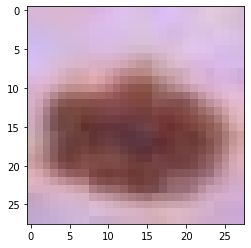

In [ ]:
idx = 2021
plt.imshow(X_train[idx])

# 1) Preprocessing

## Imbalenced dataset: Random over sampling

!!!! NOT WORKING !!!!

In [ ]:
from collections import Counter
counts = Counter(y_train)
counts

Counter({0: 228, 1: 359, 2: 769, 3: 80, 4: 779, 5: 4693, 6: 99})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


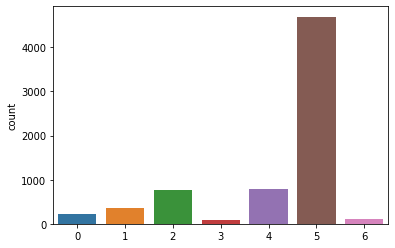

In [ ]:
sns.countplot(y_train)

In [ ]:
shape_temp = (X_train.shape[0], np.prod(X_train.shape[1:]))

factors = {0:counts[0]*18 , 1:counts[1]*12 , 2:counts[2]*6 , 3:counts[3]*53 , 4:counts[4]*6  , 6:counts[6]*46}
sampler = RandomOverSampler(random_state=2021, ratio=factors)
X_train, y_train = sampler.fit_resample(X_train.reshape(shape_temp), y_train)

shape_temp = (-1,) + image_shape

X_train = X_train.reshape(shape_temp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
idx_list = np.random.permutation(X_train.shape[0])
X_train  = X_train[idx_list, :,:,:]
y_train = y_train[idx_list,]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


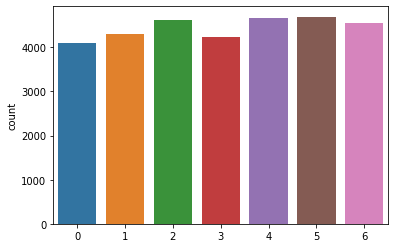

In [ ]:
sns.countplot(y_train)

## Normalize Images

In [ ]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [ ]:
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)
Y_test = to_categorical(y_test)

num_classes = Y_train.shape[1]

In [ ]:
print('Train data shapes: ', X_train.shape, Y_train.shape)
print('Train data shapes: ', X_val.shape, Y_val.shape)
print('Train data shapes: ', X_test.shape, Y_test.shape)

Train data shapes:  (7007, 28, 28, 3) (7007, 7)
Train data shapes:  (1003, 28, 28, 3) (1003, 7)
Train data shapes:  (2005, 28, 28, 3) (2005, 7)


# 2) Model Architectures


## VGG-16

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=image_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation="softmax"))

In [ ]:
model.summary()
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0

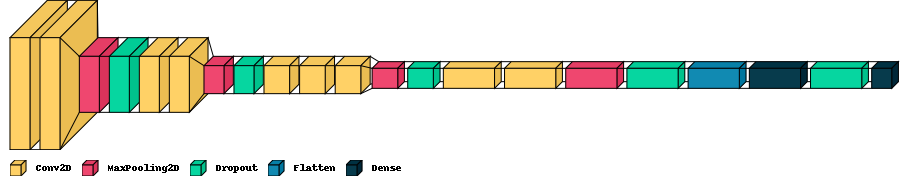

In [ ]:
font = ImageFont.load_default()
layered_view(model, legend=True, font=font,to_file='VGG_16.png')

In [ ]:
def callbacks(): 
    return [ 
            #EarlyStopping(monitor = 'val_loss', patience = 12, verbose=1), 
            ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose=1, factor=0.2, min_lr=0.00001), 
            ModelCheckpoint('Derma_best_VGG16.hdf5', save_best_only=True, verbose=1, monitor='val_acc'),
            TensorBoard('logs', histogram_freq=1, update_freq='epoch')
           ]
           
%tensorboard --logdir logs

In [ ]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=70, validation_data=(X_val, Y_val), callbacks=callbacks())

Epoch 1/70
55/55 [==============================] - 38s 124ms/step - loss: 1.7940 - acc: 0.6625 - val_loss: 1.7066 - val_acc: 0.6690

Epoch 00001: val_acc improved from -inf to 0.66899, saving model to Derma_best_VGG16.hdf5
Epoch 2/70
55/55 [==============================] - 4s 73ms/step - loss: 1.5073 - acc: 0.6698 - val_loss: 1.4954 - val_acc: 0.6690

Epoch 00002: val_acc did not improve from 0.66899
Epoch 3/70
55/55 [==============================] - 4s 75ms/step - loss: 1.4132 - acc: 0.6698 - val_loss: 1.3979 - val_acc: 0.6690

Epoch 00003: val_acc did not improve from 0.66899
Epoch 4/70
55/55 [==============================] - 4s 73ms/step - loss: 1.3335 - acc: 0.6698 - val_loss: 1.3387 - val_acc: 0.6690

Epoch 00004: val_acc did not improve from 0.66899
Epoch 5/70
55/55 [==============================] - 4s 72ms/step - loss: 1.2663 - acc: 0.6699 - val_loss: 1.2410 - val_acc: 0.6690

Epoch 00005: val_acc did not improve from 0.66899
Epoch 6/70
55/55 [==============================

In [ ]:
model.load_weights('Derma_best_VGG16.hdf5')
Y_pred = model.predict(X_test)
y_pred, y_test = Y_pred.argmax(axis=1), Y_test.argmax(axis=1)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.456     0.394     0.423        66
           1      0.449     0.515     0.480       103
           2      0.502     0.541     0.521       220
           3      1.000     0.087     0.160        23
           4      0.536     0.336     0.413       223
           5      0.860     0.917     0.888      1341
           6      0.619     0.448     0.520        29

    accuracy                          0.757      2005
   macro avg      0.632     0.463     0.486      2005
weighted avg      0.748     0.757     0.745      2005



## VGG based model

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=image_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))


model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))


model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))



model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

In [ ]:
model.summary()
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 28, 28, 64)        1792      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 14, 14, 128)      

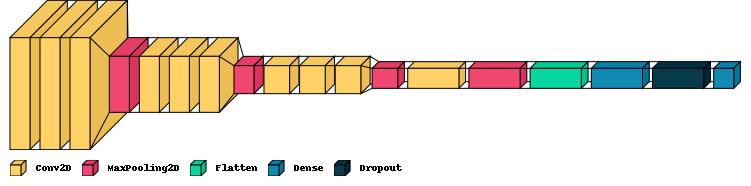

In [ ]:
font = ImageFont.load_default()
layered_view(model, legend=True, font=font,to_file='VGG_16.png')

In [ ]:
def callbacks(): 
    return [ 
            #EarlyStopping(monitor = 'val_loss', patience = 15, verbose=1), 
            ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001), 
            ModelCheckpoint('Derma_best_VGG16_based.hdf5', save_best_only=True, verbose=1, monitor='val_acc'),
            TensorBoard('logs_based', histogram_freq=1, update_freq='epoch')
           ]
           
%tensorboard --logdir logs_based

In [ ]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=80, validation_data=(X_val, Y_val), callbacks=callbacks())

Epoch 1/80
55/55 [==============================] - 6s 97ms/step - loss: 1.5124 - acc: 0.6593 - val_loss: 1.3198 - val_acc: 0.6690

Epoch 00001: val_acc improved from -inf to 0.66899, saving model to Derma_best_VGG16_based.hdf5
Epoch 2/80
55/55 [==============================] - 4s 78ms/step - loss: 1.2573 - acc: 0.6698 - val_loss: 1.1883 - val_acc: 0.6690

Epoch 00002: val_acc did not improve from 0.66899
Epoch 3/80
55/55 [==============================] - 4s 79ms/step - loss: 1.1731 - acc: 0.6698 - val_loss: 1.1334 - val_acc: 0.6690

Epoch 00003: val_acc did not improve from 0.66899
Epoch 4/80
55/55 [==============================] - 4s 78ms/step - loss: 1.1216 - acc: 0.6698 - val_loss: 1.0902 - val_acc: 0.6690

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00004: val_acc did not improve from 0.66899
Epoch 5/80
55/55 [==============================] - 4s 81ms/step - loss: 1.0794 - acc: 0.6702 - val_loss: 1.0533 - val_acc: 0.6690

Epoch 00005: 

In [ ]:
model.load_weights('Derma_best_VGG16_based.hdf5')
Y_pred = model.predict(X_test)
y_pred, y_test = Y_pred.argmax(axis=1), Y_test.argmax(axis=1)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.435     0.303     0.357        66
           1      0.461     0.398     0.427       103
           2      0.440     0.436     0.438       220
           3      0.000     0.000     0.000        23
           4      0.500     0.206     0.292       223
           5      0.819     0.942     0.876      1341
           6      0.500     0.310     0.383        29

    accuracy                          0.736      2005
   macro avg      0.451     0.371     0.396      2005
weighted avg      0.697     0.736     0.706      2005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Based on Google net

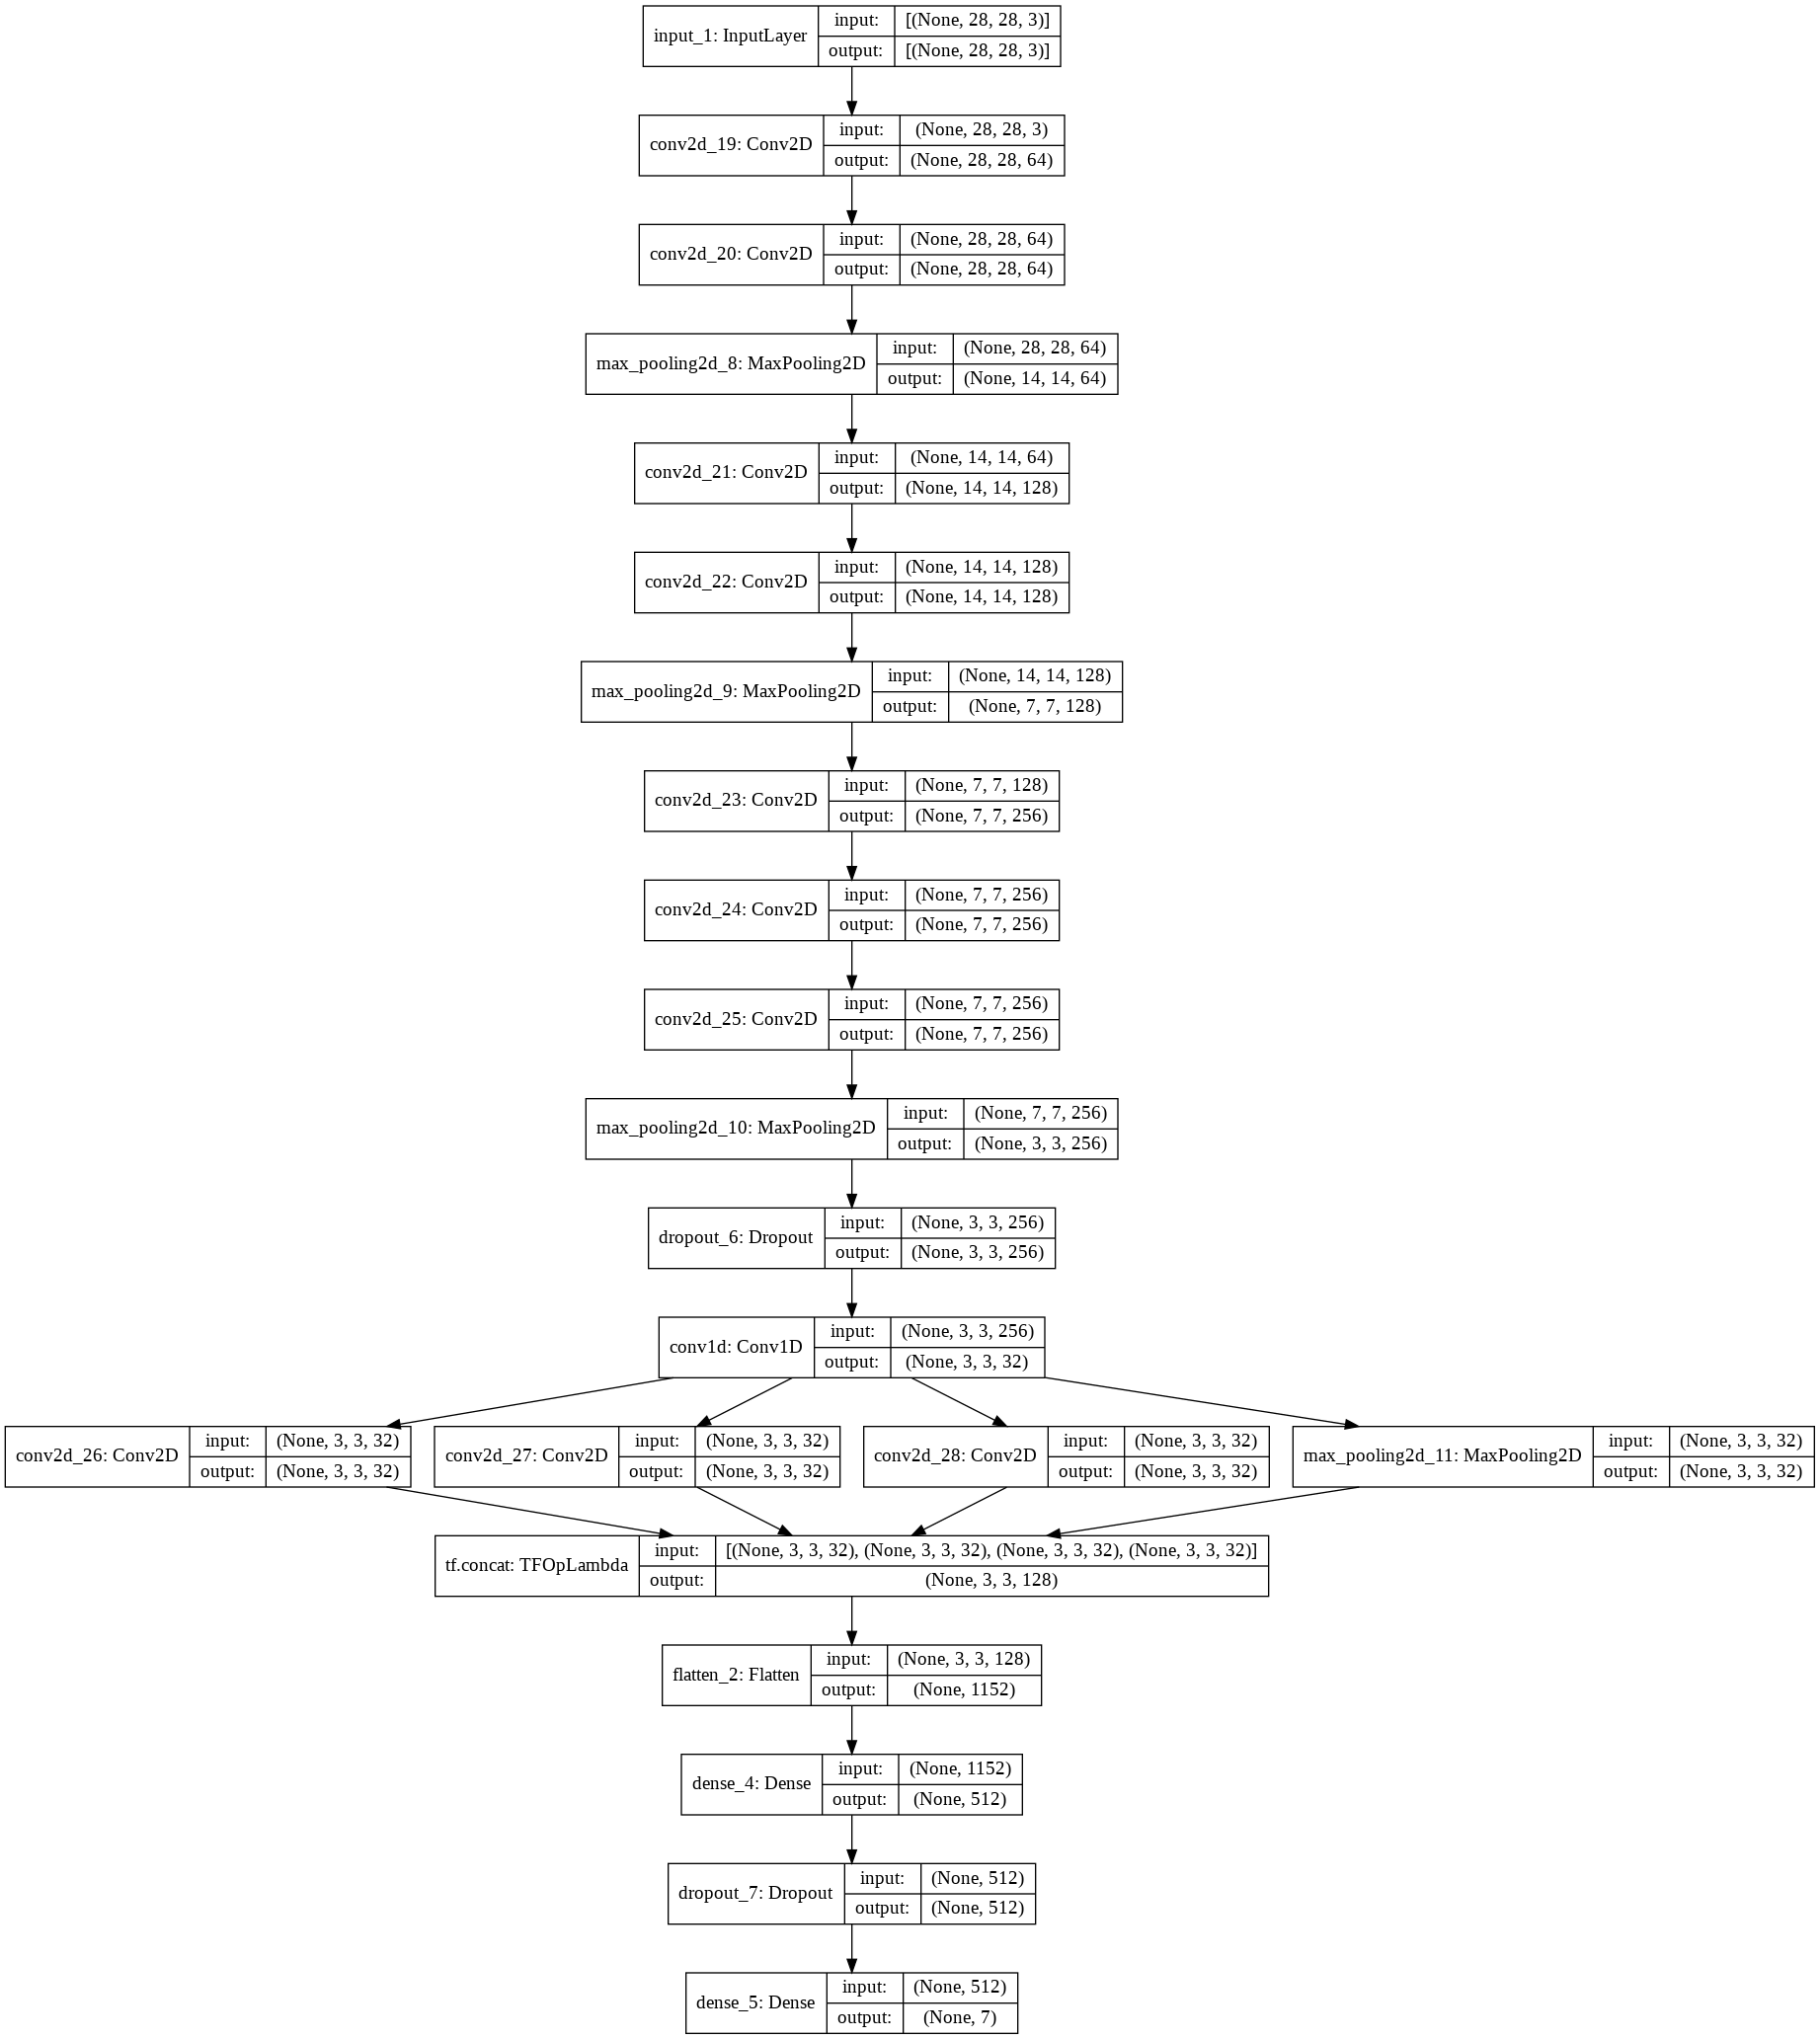

In [ ]:
input_img = Input(shape=image_shape)

  
layer_1 = Conv2D(64, (3,3), padding='same', activation='relu', input_shape=image_shape)(input_img)
layer_1 = Conv2D(64, (3,3), padding='same', activation='relu')(layer_1)
layer_1 = MaxPool2D((2,2), strides=(2,2))(layer_1)


layer_2 = Conv2D(128, (3,3), padding='same', activation='relu')(layer_1)
layer_2 = Conv2D(128, (3,3), padding='same', activation='relu')(layer_2)
layer_2 = MaxPool2D((2,2), strides=(2,2))(layer_2)

layer_3 = Conv2D(256, (3,3), padding='same', activation='relu')(layer_2)
layer_3 = Conv2D(256, (3,3), padding='same', activation='relu')(layer_3)
layer_3 = Conv2D(256, (3,3), padding='same', activation='relu')(layer_3)
layer_3 = MaxPool2D((2,2), strides=(2,2))(layer_3)
layer_3 = Dropout(0.1)(layer_3)

layer_4 = Conv1D(32, 3, padding='same', activation='relu')(layer_3)

#Inception layer
conv1 = Conv2D(32, (1,1), padding='same', activation='relu')(layer_4)
# 3x3 conv
conv3 = Conv2D(32, (3,3), padding='same', activation='relu')(layer_4)
# 5x5 conv
conv5 = Conv2D(32, (5,5), padding='same', activation='relu')(layer_4)
# 3x3 max pooling
pool = MaxPool2D((3,3), strides=(1,1), padding='same')(layer_4)
# concatenate filters, assumes filters/channels last
inception_out = concatenate([conv1, conv3, conv5, pool],axis=-1)



layer_5 = Flatten()(inception_out)

layer_6 = Dense(512, activation='relu')(layer_5)
layer_6 = Dropout(0.3)(layer_6)

final_layer = Dense(num_classes, activation='softmax')(layer_6)

model = Model([input_img], final_layer)

plot_model(model, show_shapes=True, show_layer_names=True, to_file='based on google net.png')

In [ ]:
model.summary()
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, 28, 28, 64)   1792        input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_176 (Conv2D)             (None, 28, 28, 64)   36928       conv2d_175[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_74 (MaxPooling2D) (None, 14, 14, 64)   0           conv2d_176[0][0]                 
____________________________________________________________________________________________

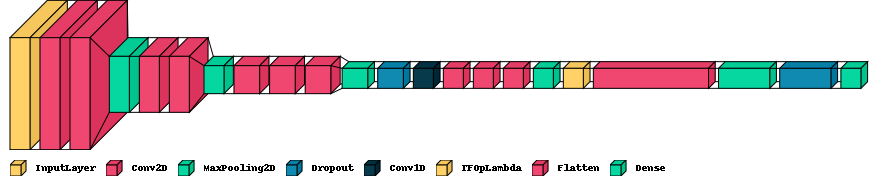

In [ ]:
font = ImageFont.load_default()
layered_view(model, legend=True, font=font,to_file='VGG_16.png')

In [ ]:
def callbacks(): 
    return [ 
            #EarlyStopping(monitor = 'val_loss', patience = 15, verbose=1), 
            ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.2, min_lr=0.00001), 
            ModelCheckpoint('Derma_best_google_net.hdf5', save_best_only=True, verbose=1, monitor='val_acc'),
            TensorBoard('logs_google_net', histogram_freq=1, update_freq='epoch')
           ]
           
%tensorboard --logdir logs_google_net

In [ ]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=70, validation_data=(X_val, Y_val), callbacks=callbacks())

Epoch 1/70
55/55 [==============================] - 5s 76ms/step - loss: 1.2237 - acc: 0.6621 - val_loss: 1.1007 - val_acc: 0.6690

Epoch 00001: val_acc improved from -inf to 0.66899, saving model to Derma_best_google_net.hdf5
Epoch 2/70
55/55 [==============================] - 3s 57ms/step - loss: 1.0460 - acc: 0.6698 - val_loss: 0.9917 - val_acc: 0.6690

Epoch 00002: val_acc did not improve from 0.66899
Epoch 3/70
55/55 [==============================] - 3s 56ms/step - loss: 0.9844 - acc: 0.6696 - val_loss: 0.9462 - val_acc: 0.6690

Epoch 00003: val_acc did not improve from 0.66899
Epoch 4/70
55/55 [==============================] - 3s 57ms/step - loss: 0.9418 - acc: 0.6743 - val_loss: 0.9000 - val_acc: 0.6700

Epoch 00004: val_acc improved from 0.66899 to 0.66999, saving model to Derma_best_google_net.hdf5
Epoch 5/70
55/55 [==============================] - 3s 57ms/step - loss: 0.9070 - acc: 0.6836 - val_loss: 0.8625 - val_acc: 0.6859

Epoch 00005: val_acc improved from 0.66999 to 0

In [ ]:
model.load_weights('Derma_best_google_net.hdf5')
Y_pred = model.predict(X_test)
y_pred, y_test = Y_pred.argmax(axis=1), Y_test.argmax(axis=1)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.410     0.379     0.394        66
           1      0.435     0.583     0.498       103
           2      0.560     0.464     0.507       220
           3      0.000     0.000     0.000        23
           4      0.563     0.318     0.407       223
           5      0.846     0.931     0.886      1341
           6      0.591     0.448     0.510        29

    accuracy                          0.758      2005
   macro avg      0.486     0.446     0.457      2005
weighted avg      0.734     0.758     0.739      2005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 3) Different Activation Functions

In [ ]:
def callbacks(): 
    return [ 
            #EarlyStopping(monitor = 'val_loss', patience = 12, verbose=1), 
            ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose=1, factor=0.2, min_lr=0.00001), 
            ModelCheckpoint('Derma_best_VGG16.hdf5', save_best_only=True, verbose=1, monitor='val_acc')
           ]
           
funcs = ['relu', 'sigmoid', 'tanh']
histories = []
for fun in funcs:

  model = Sequential()

  model.add(Conv2D(64, (3, 3), activation=fun, padding='same', input_shape=image_shape))
  model.add(Conv2D(64, (3, 3), activation=fun, padding='same'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), activation=fun, padding='same', kernel_regularizer=l2(0.001)))
  model.add(Conv2D(128, (3, 3), activation=fun, padding='same'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(256, (3, 3), activation=fun, padding='same', kernel_regularizer=l2(0.001)))
  model.add(Conv2D(256, (3, 3), activation=fun, padding='same'))
  model.add(Conv2D(256, (3, 3), activation=fun, padding='same'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(512, (3, 3), activation=fun, padding='same', kernel_regularizer=l2(0.001)))
  model.add(Conv2D(512, (3, 3), activation=fun, padding='same'))
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Dropout(0.3))


  model.add(Flatten())
  model.add(Dense(512, activation=fun))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation="softmax"))

  model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])
  history = model.fit(X_train, Y_train, batch_size=128, epochs=35, validation_data=(X_val, Y_val), callbacks=callbacks())
  histories.append(history)

Epoch 1/35
55/55 [==============================] - 10s 116ms/step - loss: 1.8019 - acc: 0.6631 - val_loss: 1.7226 - val_acc: 0.6690

Epoch 00001: val_acc improved from -inf to 0.66899, saving model to Derma_best_VGG16.hdf5
Epoch 2/35
55/55 [==============================] - 4s 74ms/step - loss: 1.5003 - acc: 0.6698 - val_loss: 1.5096 - val_acc: 0.6690

Epoch 00002: val_acc did not improve from 0.66899
Epoch 3/35
55/55 [==============================] - 4s 77ms/step - loss: 1.4001 - acc: 0.6698 - val_loss: 1.4179 - val_acc: 0.6690

Epoch 00003: val_acc did not improve from 0.66899
Epoch 4/35
55/55 [==============================] - 4s 74ms/step - loss: 1.3303 - acc: 0.6698 - val_loss: 1.3065 - val_acc: 0.6690

Epoch 00004: val_acc did not improve from 0.66899
Epoch 5/35
55/55 [==============================] - 4s 74ms/step - loss: 1.2732 - acc: 0.6698 - val_loss: 1.2289 - val_acc: 0.6690

Epoch 00005: val_acc did not improve from 0.66899
Epoch 6/35
55/55 [==============================

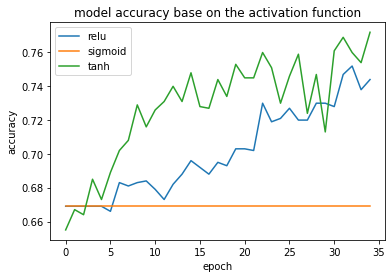

In [ ]:
for his in histories:
  plt.plot(his.history['val_acc'])

plt.title('model accuracy base on the activation function')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['relu', 'sigmoid', 'tanh'], loc='best')

# 4) Different Hyperparameters

In [ ]:
def callbacks(): 
    return [ 
            #EarlyStopping(monitor = 'val_loss', patience = 12, verbose=1), 
            ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose=1, factor=0.2, min_lr=0.00001)
           ]

## change filter size

In [ ]:

model = Sequential()

model.add(Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=image_shape))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(512, (5, 5), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation="softmax"))
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=35, validation_data=(X_val, Y_val), callbacks=callbacks())

Epoch 1/35
55/55 [==============================] - 17s 241ms/step - loss: 1.7185 - acc: 0.6622 - val_loss: 1.4979 - val_acc: 0.6690

Epoch 00001: val_acc improved from -inf to 0.66899, saving model to Derma_best_VGG16.hdf5
Epoch 2/35
55/55 [==============================] - 9s 166ms/step - loss: 1.4360 - acc: 0.6698 - val_loss: 1.3836 - val_acc: 0.6690

Epoch 00002: val_acc did not improve from 0.66899
Epoch 3/35
55/55 [==============================] - 9s 166ms/step - loss: 1.3449 - acc: 0.6698 - val_loss: 1.2878 - val_acc: 0.6690

Epoch 00003: val_acc did not improve from 0.66899
Epoch 4/35
55/55 [==============================] - 9s 167ms/step - loss: 1.2905 - acc: 0.6698 - val_loss: 1.2178 - val_acc: 0.6690

Epoch 00004: val_acc did not improve from 0.66899
Epoch 5/35
55/55 [==============================] - 9s 167ms/step - loss: 1.2299 - acc: 0.6698 - val_loss: 1.1760 - val_acc: 0.6690

Epoch 00005: val_acc did not improve from 0.66899
Epoch 6/35
55/55 [==========================

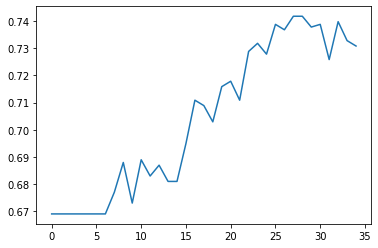

In [ ]:
plt.plot(history.history['val_acc'])

## change kernel size in Pooling layer

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=image_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((3, 3), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((3, 3), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((3, 3), strides=(1, 1)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((3, 3), strides=(2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation="softmax"))
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=25, validation_data=(X_val, Y_val), callbacks=callbacks())

Epoch 1/25
55/55 [==============================] - 8s 104ms/step - loss: 1.7945 - acc: 0.6579 - val_loss: 1.7383 - val_acc: 0.6690

Epoch 00001: val_acc improved from -inf to 0.66899, saving model to Derma_best_VGG16.hdf5
Epoch 2/25
55/55 [==============================] - 4s 75ms/step - loss: 1.5158 - acc: 0.6698 - val_loss: 1.5122 - val_acc: 0.6690

Epoch 00002: val_acc did not improve from 0.66899
Epoch 3/25
55/55 [==============================] - 4s 75ms/step - loss: 1.4305 - acc: 0.6698 - val_loss: 1.4626 - val_acc: 0.6690

Epoch 00003: val_acc did not improve from 0.66899
Epoch 4/25
55/55 [==============================] - 4s 75ms/step - loss: 1.3567 - acc: 0.6698 - val_loss: 1.3292 - val_acc: 0.6690

Epoch 00004: val_acc did not improve from 0.66899
Epoch 5/25
55/55 [==============================] - 4s 75ms/step - loss: 1.2843 - acc: 0.6696 - val_loss: 1.2520 - val_acc: 0.6839

Epoch 00005: val_acc improved from 0.66899 to 0.68395, saving model to Derma_best_VGG16.hdf5
Epoch 

In [ ]:
plt.plot(history.history['val_acc'])

## change Stride

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=image_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(4, 4)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(4, 4)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(4, 4)))
model.add(Dropout(0.3))

# model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D((2, 2), strides=(4, 4)))
# model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation="softmax"))
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=25, validation_data=(X_val, Y_val), callbacks=callbacks())

Epoch 1/25
55/55 [==============================] - 4s 47ms/step - loss: 1.5842 - acc: 0.6606 - val_loss: 1.3578 - val_acc: 0.6690

Epoch 00001: val_acc improved from -inf to 0.66899, saving model to Derma_best_VGG16.hdf5
Epoch 2/25
55/55 [==============================] - 2s 33ms/step - loss: 1.3190 - acc: 0.6698 - val_loss: 1.2539 - val_acc: 0.6690

Epoch 00002: val_acc did not improve from 0.66899
Epoch 3/25
55/55 [==============================] - 2s 35ms/step - loss: 1.2338 - acc: 0.6698 - val_loss: 1.1993 - val_acc: 0.6690

Epoch 00003: val_acc did not improve from 0.66899
Epoch 4/25
55/55 [==============================] - 2s 33ms/step - loss: 1.1874 - acc: 0.6698 - val_loss: 1.1669 - val_acc: 0.6690

Epoch 00004: val_acc did not improve from 0.66899
Epoch 5/25
55/55 [==============================] - 2s 33ms/step - loss: 1.1577 - acc: 0.6698 - val_loss: 1.1243 - val_acc: 0.6690

Epoch 00005: val_acc did not improve from 0.66899
Epoch 6/25
55/55 [==============================] 

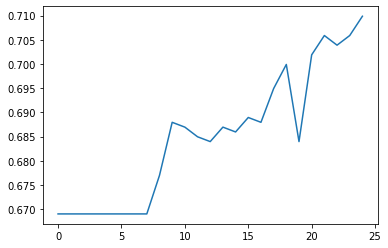

In [ ]:
plt.plot(history.history['val_acc'])

## use average pooling

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=image_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(AvgPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(AvgPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(AvgPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(AvgPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation="softmax"))
model.summary()
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=70, validation_data=(X_val, Y_val), callbacks=callbacks())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 28, 28, 64)        1792      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 128)        